## Data preprocessing (feak. KoNLPy)

In [7]:
def read_data(filename):
    with open(filename, 'rt', encoding='UTF8') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:] # erase header
    return data

In [8]:
train_data = read_data('./nsmc/ratings_train.txt')
test_data = read_data('./nsmc/ratings_test.txt')

print(len(train_data))
print(len(train_data[0]))
print(len(test_data))
print(len(test_data[0]))


150000
3
50000
3


## POS analyzer

In [8]:
from pprint import pprint
'''from konlpy.tag import Twitter

pos_tagger = Twitter()
def tokenize(doc):
    return ['/'.join(t) for t in pos_tagger.pos(doc,norm = True, stem = True)]

train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
test_docs = [(tokenize(row[1]), row[2]) for row in test_data]

print(len(train_docs),len(train_docs[0]))
pprint(train_docs[0])'''

"from konlpy.tag import Twitter\n\npos_tagger = Twitter()\ndef tokenize(doc):\n    return ['/'.join(t) for t in pos_tagger.pos(doc,norm = True, stem = True)]\n\ntrain_docs = [(tokenize(row[1]), row[2]) for row in train_data]\ntest_docs = [(tokenize(row[1]), row[2]) for row in test_data]\n\nprint(len(train_docs),len(train_docs[0]))\npprint(train_docs[0])"

In [2]:
import pickle
'''
with open('train_docs.txt','wb') as fp :
    pickle.dump(train_docs,fp)
with open('test_docs.txt','wb') as fp :
    pickle.dump(test_docs,fp)'''

"\nwith open('train_docs.txt','wb') as fp :\n    pickle.dump(train_docs,fp)\nwith open('test_docs.txt','wb') as fp :\n    pickle.dump(test_docs,fp)"

In [4]:
with open('train_docs.txt','rb') as fp:
    train_docs = pickle.load(fp)
with open('test_docs.txt','rb') as fp:
    test_docs = pickle.load(fp)
#pprint(train_docs[0])
print(len(train_docs),len(train_docs[0]))

150000 2


In [27]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

2194536


In [29]:
import nltk
text = nltk.Text(tokens, name= 'NMSC')
print(text)

<Text: NMSC>


In [30]:
print(len(text.tokens))
print(len(set(text.tokens)))
pprint(text.vocab().most_common(10))

2194536
48765
[('./Punctuation', 68630),
 ('영화/Noun', 51365),
 ('하다/Verb', 50281),
 ('이/Josa', 39123),
 ('보다/Verb', 34764),
 ('의/Josa', 30480),
 ('../Punctuation', 29055),
 ('에/Josa', 27108),
 ('가/Josa', 26696),
 ('을/Josa', 23481)]


## Data exploration (feat. NLTK)

In [38]:
from matplotlib import font_manager, rc
font_fname = 'c:/windows/fonts/H2GTRE.TTF'     # A font of your choice
font_name = font_manager.FontProperties(fname=font_fname).get_name()
print(font_name)
rc('font', family=font_name)

HYGothic-Extra


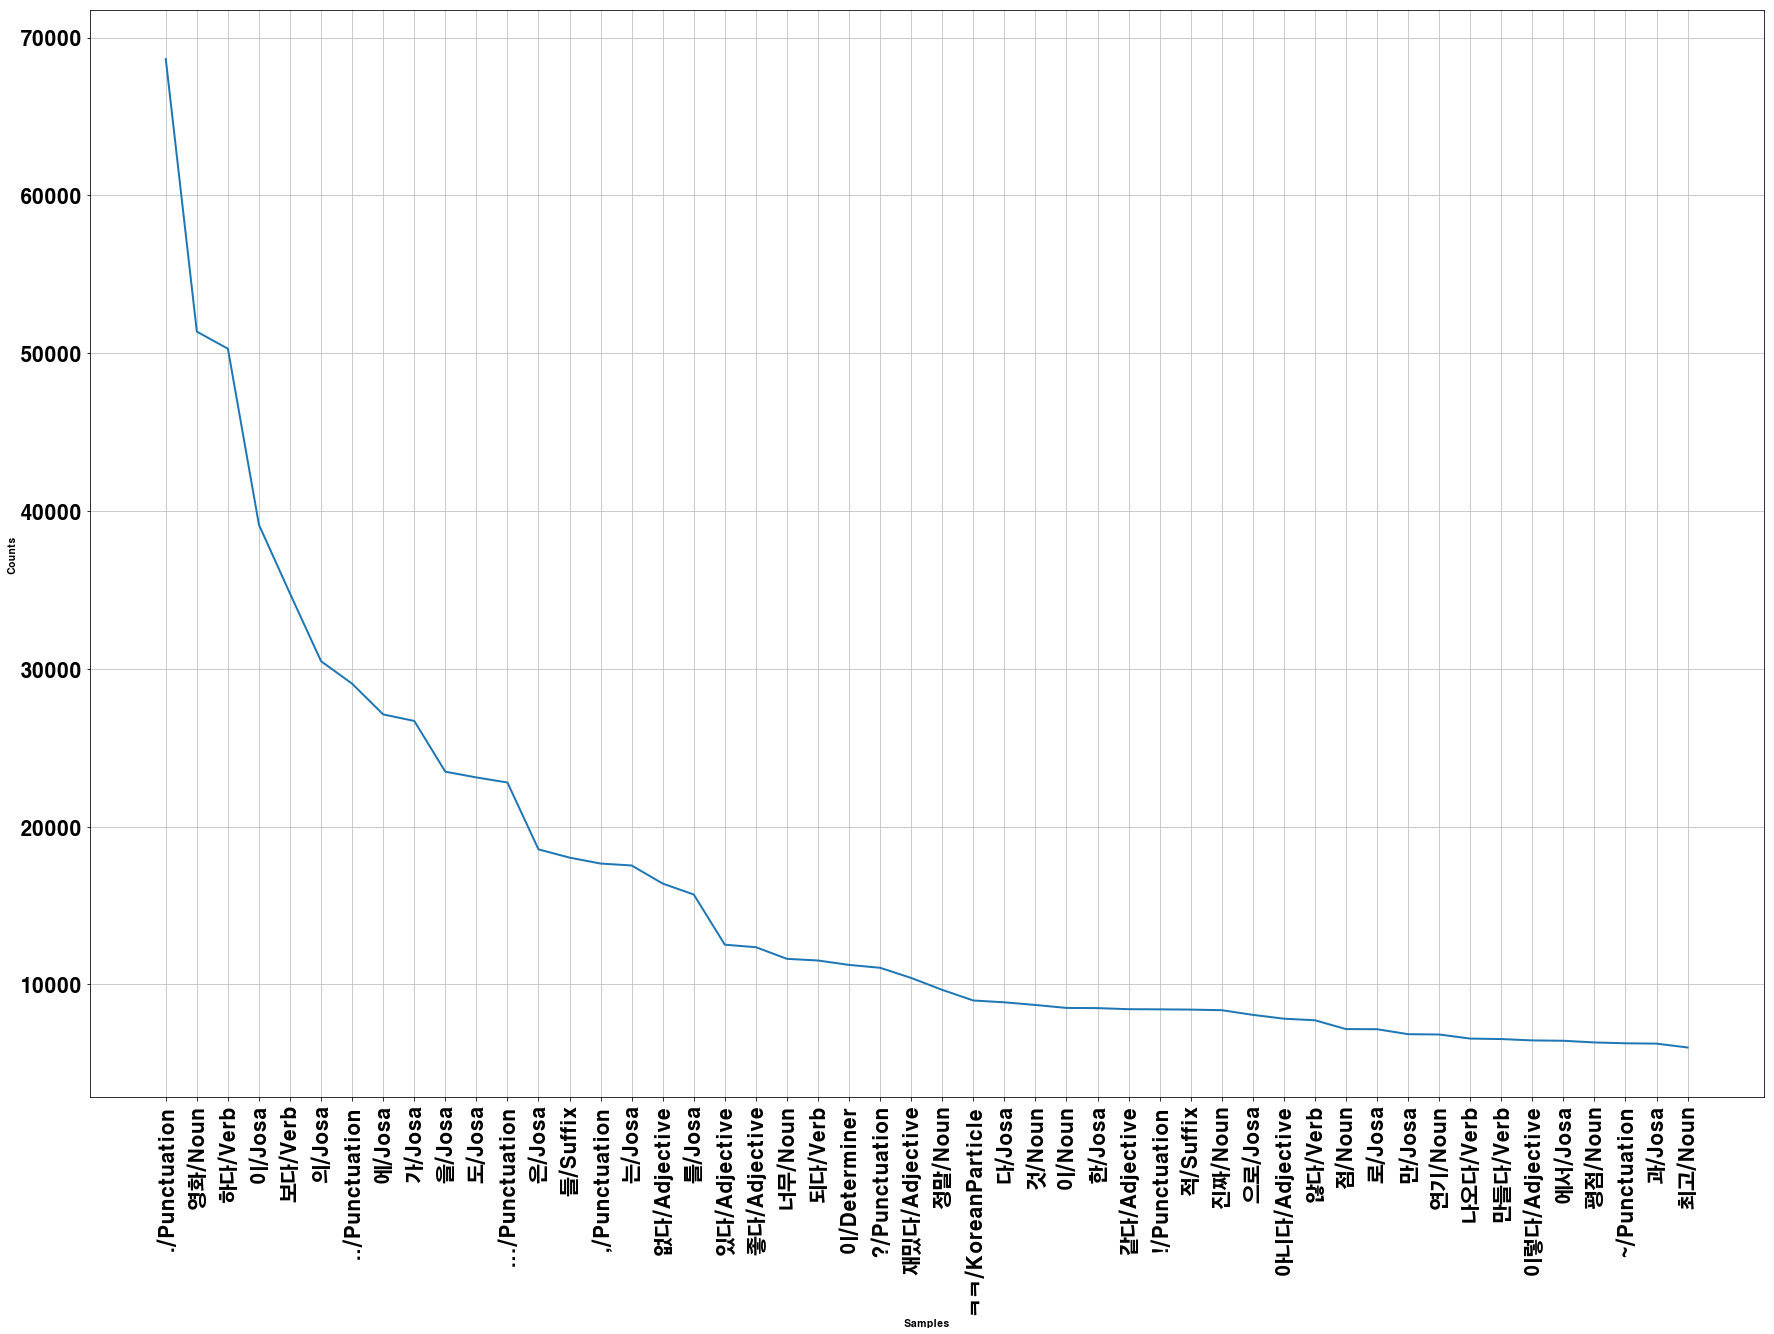

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 20))
plt.tick_params(labelsize=20)
text.plot(50)

In [ ]:
text.collocations

## Sentiment classification with term-existance

In [43]:
# 여기서는 최빈도 단어 2000개를 피쳐로 사용
# WARNING: 쉬운 이해를 위한 코드이며 time/memory efficient하지 않습니다
selected_words = [f[0] for f in text.vocab().most_common(2000)]
def term_exists(doc):
    return {'exists({})'.format(word): (word in set(doc)) for word in selected_words}
# 시간 단축을 위한 꼼수로 training corpus의 일부만 사용할 수 있음
train_docs = train_docs[:10000]
train_xy = [(term_exists(d), c) for d, c in train_docs]
test_xy = [(term_exists(d), c) for d, c in test_docs]

* Naive Bayes classifier 적용

In [44]:
# 초간단함
classifier = nltk.NaiveBayesClassifier.train(train_xy)
print(nltk.classify.accuracy(classifier, test_xy))
# => 0.80418
classifier.show_most_informative_features(10)

0.80408
Most Informative Features
         exists(수작/Noun) = True                1 : 0      =     38.0 : 1.0
         exists(최악/Noun) = True                0 : 1      =     30.1 : 1.0
       exists(♥/Foreign) = True                1 : 0      =     24.5 : 1.0
         exists(노잼/Noun) = True                0 : 1      =     22.1 : 1.0
         exists(낭비/Noun) = True                0 : 1      =     19.5 : 1.0
        exists(쓰레기/Noun) = True                0 : 1      =     19.4 : 1.0
         exists(여운/Noun) = True                1 : 0      =     18.9 : 1.0
        exists(발연기/Noun) = True                0 : 1      =     16.9 : 1.0
          exists(굿/Noun) = True                1 : 0      =     16.9 : 1.0
        exists(최고다/Noun) = True                1 : 0      =     15.9 : 1.0


### Sentiment classification with doc2vec (feat. Gensim)

In [5]:
from collections import namedtuple

TaggedDocument = namedtuple('TaggedDocument', 'words tags')
# 여기서는 15만개 training documents 전부 사용함
tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]
tagged_test_docs = [TaggedDocument(d, [c]) for d, c in test_docs]

In [7]:
print(len(tagged_train_docs),len(tagged_train_docs[0]))
print(tagged_train_docs[0])

150000 2
TaggedDocument(words=['아/Exclamation', '더빙/Noun', '../Punctuation', '진짜/Noun', '짜증/Noun', '나다/Verb', '목소리/Noun'], tags=['0'])


In [15]:
from gensim.models import doc2vec

# 사전 구축
doc_vectorizer = doc2vec.Doc2Vec(size=300, alpha=0.025, min_alpha=0.005, seed=1234)
doc_vectorizer.build_vocab(tagged_train_docs)
print(doc_vectorizer.corpus_count,doc_vectorizer.iter,doc_vectorizer.alpha,doc_vectorizer.min_alpha)

# Train document vectors!
doc_vectorizer.train(tagged_train_docs, total_examples = doc_vectorizer.corpus_count, epochs = doc_vectorizer.iter)
# To save
doc_vectorizer.save('doc2vec.model')

150000 5 0.025 0.005
150000 5


In [16]:
pprint(doc_vectorizer.most_similar('공포/Noun'))

[('스릴러/Noun', 0.8144225478172302),
 ('코미디/Noun', 0.7995042204856873),
 ('미스터리/Noun', 0.7664399147033691),
 ('판타지/Noun', 0.7337913513183594),
 ('서스펜스/Noun', 0.7330292463302612),
 ('로맨스/Noun', 0.7314857244491577),
 ('장르/Noun', 0.7173519134521484),
 ('멜로/Noun', 0.7097760438919067),
 ('공포영화/Noun', 0.7079706788063049),
 ('다큐멘터리/Noun', 0.7052273750305176)]


In [17]:
pprint(doc_vectorizer.most_similar('ㅋㅋ/KoreanParticle'))

[('ㅋ/KoreanParticle', 0.6335453987121582),
 ('ㅎㅎ/KoreanParticle', 0.6253126859664917),
 ('^^^/Punctuation', 0.5682340860366821),
 ('ㅅㅂ/KoreanParticle', 0.560049295425415),
 ('빵/Noun', 0.5256726741790771),
 (';;;/Punctuation', 0.5138247609138489),
 ('존나/Noun', 0.5055084228515625),
 ('>_</Punctuation', 0.5054813623428345),
 ('겁나다/Verb', 0.5024611949920654),
 ('-_-/Punctuation', 0.49841010570526123)]


In [18]:
pprint(doc_vectorizer.most_similar(positive=['여자/Noun', '왕/Noun'], negative=['남자/Noun']))

[('비행선/Noun', 0.6042666435241699),
 ('구혜선/Noun', 0.5983981490135193),
 ('캐릭/Noun', 0.583044171333313),
 ('한가인/Noun', 0.5779954195022583),
 ('하지원/Noun', 0.5724408626556396),
 ('여신/Noun', 0.5711207985877991),
 ('하나경/Noun', 0.5640947818756104),
 ('김하늘/Noun', 0.5619147419929504),
 ('전효성/Noun', 0.5597392916679382),
 ('함정/Noun', 0.5562903881072998)]


In [ ]:
# text.concordance('왕/Noun', lines=10)

In [19]:
train_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs]
train_y = [doc.tags[0] for doc in tagged_train_docs]
len(train_x)       # 사실 이 때문에 앞의 term existance와는 공평한 비교는 아닐 수 있다
# => 150000
len(train_x[0])
# => 300
test_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_test_docs]
test_y = [doc.tags[0] for doc in tagged_test_docs]
len(test_x)
# => 50000
len(test_x[0])
# => 300

300

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x, train_y)
classifier.score(test_x, test_y)